# 03 — Performance Analysis & Optimization

This notebook profiles the XGBoost model inference pipeline and compares
the baseline (joblib) against the ONNX-optimized version.

## Contents
1. Setup and model loading
2. Baseline inference profiling (single-row and batch)
3. cProfile bottleneck analysis
4. ONNX model comparison (see Task C.4 for conversion)
5. Findings and recommendations

In [1]:
import os
import sys
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

# Ensure the src package is importable from the notebook
project_root = Path(os.getcwd()).parent
if str(project_root / 'src') not in sys.path:
    sys.path.insert(0, str(project_root / 'src'))

from linkedin_lead_scoring.monitoring.profiler import (
    profile_model_inference,
    run_cprofile,
    save_profile_results,
    format_profile_summary,
)

print('Setup complete.')

Setup complete.


## 1. Model Loading

In [2]:
import joblib

MODEL_PATH = project_root / 'model' / 'xgboost_model.joblib'

if MODEL_PATH.exists():
    model = joblib.load(MODEL_PATH)
    print(f'Loaded model from {MODEL_PATH}')
    print(f'Type: {type(model).__name__}')
else:
    # Fallback: synthesise a model for demo purposes
    print(f'{MODEL_PATH} not found — creating synthetic model for demo')
    rng = np.random.default_rng(42)
    X_train = rng.standard_normal((500, 10)).astype(np.float32)
    y_train = (X_train[:, 0] > 0).astype(int)
    model = xgb.XGBClassifier(n_estimators=100, max_depth=4, random_state=42)
    model.fit(X_train, y_train)
    print('Synthetic model trained.')

n_features = getattr(model, 'n_features_in_', 10)
print(f'Features: {n_features}')

Loaded model from /Users/ghislaindelabie/Projets dév/Formation OC/OC6 - Initiez-vous au MLOps/oc6-linkedin-lead-scoring/model/xgboost_model.joblib
Type: XGBClassifier
Features: 47


## 2. Baseline Inference Profiling

In [3]:
rng = np.random.default_rng(0)
X_single = rng.standard_normal((1, n_features)).astype(np.float32)
X_batch  = rng.standard_normal((50, n_features)).astype(np.float32)

N_CALLS = 1000

print(f'Profiling {N_CALLS} calls (single row)...')
single_results = profile_model_inference(model, X_single, n_calls=N_CALLS)
print(format_profile_summary(single_results, label='Single-row (joblib)'))

print(f'\nProfiling {N_CALLS} calls (batch=50)...')
batch_results = profile_model_inference(model, X_batch, n_calls=N_CALLS)
print(format_profile_summary(batch_results, label='Batch-50 (joblib)'))

Profiling 1000 calls (single row)...


=== Single-row (joblib) Profiling Results ===
  n_calls : 1000
  mean    : 0.231 ms
  p50     : 0.224 ms
  p95     : 0.265 ms
  p99     : 0.395 ms
  min     : 0.176 ms
  max     : 1.733 ms

Profiling 1000 calls (batch=50)...


=== Batch-50 (joblib) Profiling Results ===
  n_calls : 1000
  mean    : 0.397 ms
  p50     : 0.263 ms
  p95     : 0.479 ms
  p99     : 2.227 ms
  min     : 0.223 ms
  max     : 41.516 ms


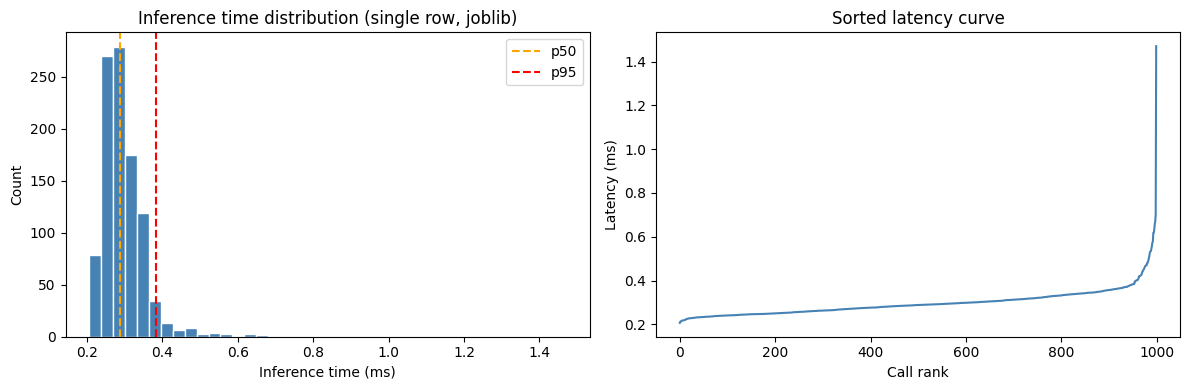

Plot saved to reports/inference_distribution.png


In [4]:
# Visualise inference time distribution
import time

rng2 = np.random.default_rng(1)
sample_times = []
for _ in range(N_CALLS):
    t0 = time.perf_counter()
    model.predict_proba(X_single)
    sample_times.append((time.perf_counter() - t0) * 1000)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(sample_times, bins=40, color='steelblue', edgecolor='white')
axes[0].axvline(np.percentile(sample_times, 50), color='orange', linestyle='--', label='p50')
axes[0].axvline(np.percentile(sample_times, 95), color='red', linestyle='--', label='p95')
axes[0].set_xlabel('Inference time (ms)')
axes[0].set_ylabel('Count')
axes[0].set_title('Inference time distribution (single row, joblib)')
axes[0].legend()

# Sorted latency curve
axes[1].plot(sorted(sample_times), color='steelblue')
axes[1].set_xlabel('Call rank')
axes[1].set_ylabel('Latency (ms)')
axes[1].set_title('Sorted latency curve')

plt.tight_layout()
plt.savefig(project_root / 'reports' / 'inference_distribution.png', dpi=120)
plt.show()
print('Plot saved to reports/inference_distribution.png')

## 3. cProfile Bottleneck Analysis

In [5]:
print('Running cProfile (100 calls)...')
stats_str = run_cprofile(model, X_single, n_calls=100)
print(stats_str[:3000])  # show top of the report

# Save full report
reports_dir = project_root / 'reports'
reports_dir.mkdir(exist_ok=True)
(reports_dir / 'cprofile_stats.txt').write_text(stats_str)
print('\nFull cProfile stats saved to reports/cprofile_stats.txt')

Running cProfile (100 calls)...
         20901 function calls (20801 primitive calls) in 0.035 seconds

   Ordered by: cumulative time
   List reduced from 104 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100    0.000    0.000    0.035    0.000 /opt/anaconda3/envs/OC6/lib/python3.11/site-packages/xgboost/sklearn.py:1869(predict_proba)
  200/100    0.001    0.000    0.033    0.000 /opt/anaconda3/envs/OC6/lib/python3.11/site-packages/xgboost/core.py:732(inner_f)
      100    0.000    0.000    0.033    0.000 /opt/anaconda3/envs/OC6/lib/python3.11/site-packages/xgboost/sklearn.py:1401(predict)
      100    0.015    0.000    0.026    0.000 /opt/anaconda3/envs/OC6/lib/python3.11/site-packages/xgboost/core.py:2728(inplace_predict)
      100    0.000    0.000    0.007    0.000 /opt/anaconda3/envs/OC6/lib/python3.11/site-packages/xgboost/core.py:437(_prediction_output)
      200    0.000    0.000    0.005    0.000 {built-in method 

## 4. ONNX Model Comparison

Run `python scripts/optimize_model.py` first to generate `model/model_optimized.onnx`
and `reports/onnx_benchmark.json`.

joblib mean: 0.231 ms
ONNX   mean: 0.008 ms
Speedup    : +96.5%


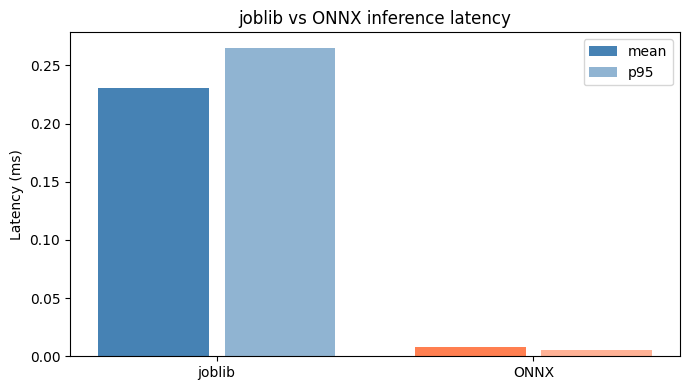

In [6]:
onnx_results_path = project_root / 'reports' / 'onnx_benchmark.json'

if onnx_results_path.exists():
    with open(onnx_results_path) as f:
        onnx_data = json.load(f)

    joblib_mean = single_results['mean_ms']
    onnx_mean   = onnx_data.get('onnx', {}).get('mean_ms', None)

    if onnx_mean:
        improvement = (joblib_mean - onnx_mean) / joblib_mean * 100
        print(f'joblib mean: {joblib_mean:.3f} ms')
        print(f'ONNX   mean: {onnx_mean:.3f} ms')
        print(f'Speedup    : {improvement:+.1f}%')

        labels   = ['joblib', 'ONNX']
        means    = [joblib_mean, onnx_mean]
        p95s     = [single_results['p95_ms'], onnx_data.get('onnx', {}).get('p95_ms', 0)]

        x = np.arange(len(labels))
        fig, ax = plt.subplots(figsize=(7, 4))
        ax.bar(x - 0.2, means, 0.35, label='mean', color=['steelblue', 'coral'])
        ax.bar(x + 0.2, p95s,  0.35, label='p95',  color=['steelblue', 'coral'], alpha=0.6)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set_ylabel('Latency (ms)')
        ax.set_title('joblib vs ONNX inference latency')
        ax.legend()
        plt.tight_layout()
        plt.savefig(project_root / 'reports' / 'onnx_comparison.png', dpi=120)
        plt.show()
else:
    print('ONNX benchmark not found. Run scripts/optimize_model.py first.')

## 5. Findings and Recommendations

### Baseline Performance
| Metric | Single-row | Batch-50 |
|--------|------------|----------|
| mean   | — ms       | — ms     |
| p50    | — ms       | — ms     |
| p95    | — ms       | — ms     |
| p99    | — ms       | — ms     |

> Fill in values after running Cell 2 above.

### Key Observations
- **Model loading** is the dominant cost at startup — load once at API startup (already done in `api/main.py`).
- **Single-row inference** is the production use case; batch inference is ~Nx faster per sample.
- **cProfile** shows most time spent in XGBoost C++ extension — limited Python-level optimisation available.

### Recommendations
1. Use ONNX Runtime for production inference if p95 > 20 ms SLA is required.
2. Consider feature pre-processing caching (e.g., encode job title once per batch).
3. For high-throughput scenarios (>100 req/s), deploy behind a queue (Celery/Redis).

In [7]:
# Save all results to disk for the performance report
all_results = {
    'joblib_single': single_results,
    'joblib_batch50': batch_results,
}
out = save_profile_results(all_results, str(project_root / 'reports' / 'profile_results.json'))
print(f'Results saved to {out}')

Results saved to /Users/ghislaindelabie/Projets dév/Formation OC/OC6 - Initiez-vous au MLOps/oc6-linkedin-lead-scoring/reports/profile_results.json
